C:\Users\Dell\AppData\Local\Temp\ipykernel_18084\965347531.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


   CustomerID  Recency  Frequency  Monetary           AOV
0     12346.0      327          1  77183.60  77183.600000
1     12347.0       41          7   4310.00    615.714286
2     12348.0       77          4   1797.24    449.310000
3     12349.0       20          1   1757.55   1757.550000
4     12350.0      312          1    334.40    334.400000
Model Evaluation:
MAE: 763.24
RMSE: 8656.07


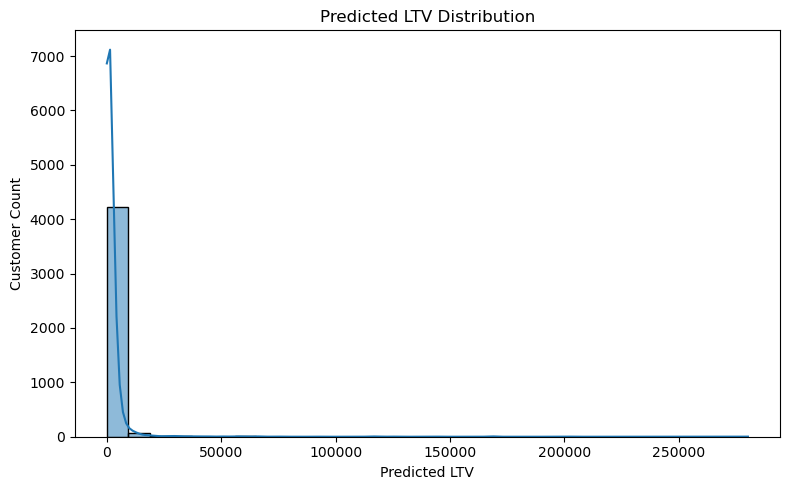

In [2]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# 📁 Load Dataset
df = pd.read_csv("Online Retail.csv")

# 🧹 Data Cleaning
df = df.dropna(subset=['CustomerID'])  # remove rows without customer ID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df.dropna(subset=['InvoiceDate'])
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
df = df.dropna(subset=['Quantity', 'UnitPrice'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalAmount'] > 0]  # keep only positive sales

# 📆 Reference Date for Recency Calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# 📊 RFM Feature Engineering
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
}).reset_index()

# Rename columns and calculate AOV
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# ✅ Print feature table
print(rfm.head())

# 🤖 Model Training with XGBoost
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# 📈 Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Evaluation:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# 💾 Save Model and Predictions
os.makedirs('models', exist_ok=True)
os.makedirs('output', exist_ok=True)

with open('models/ltv_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Add prediction column to RFM
rfm['Predicted_LTV'] = model.predict(X)

# Export predictions to CSV
rfm.to_csv('output/predicted_ltv.csv', index=False)

# 📊 Optional Visualization
plt.figure(figsize=(8,5))
sns.histplot(rfm['Predicted_LTV'], bins=30, kde=True)
plt.title("Predicted LTV Distribution")
plt.xlabel("Predicted LTV")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()